In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_moons, make_circles

In [5]:
class SigmoidNeuron:

## initialisation
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

## calculating loss by gradient descent and cross entropy 
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
          
      m = X.shape[1]  
      self.w -= learning_rate * dw/m
      self.b -= learning_rate * db/m
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [27]:
class FFSNNetwork:
  
  def __init__(self, n_inputs, hidden_sizes=[2]):
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, x):
    return x*(1-x) 
    
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
    
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    
    # initialise w, b
    if initialise:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    if display_loss:
      loss = {}
    
    for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
        
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

In [6]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

## Dataset-1

In [18]:
#Binary Classification
data, labels = make_moons(n_samples=1000, random_state=0, noise=0.15)
print(data.shape, labels.shape)

(1000, 2) (1000,)


In [19]:
data

array([[ 2.06442965,  0.54606909],
       [ 1.76247326, -0.0626892 ],
       [-0.24548973,  0.66886802],
       ...,
       [ 0.35132285, -0.53361311],
       [ 0.15631506,  0.08097761],
       [ 0.51401549, -0.50367604]])

In [20]:
labels

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,

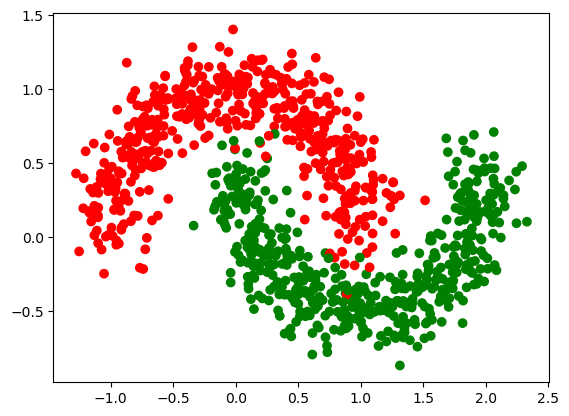

In [21]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [22]:
## spliting in train and validation
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


In [23]:
X_train

array([[ 0.73827941,  0.78616748],
       [ 0.80833201, -0.42550557],
       [ 0.78481921, -0.62664927],
       ...,
       [ 0.84574001, -0.25514043],
       [-0.85689755,  0.74746159],
       [ 0.79016668, -0.13964549]])

In [24]:
Y_train

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,

In [25]:
X_val

array([[-6.50678718e-02,  7.31005906e-01],
       [-1.03499432e-01,  2.77993199e-01],
       [ 9.16682269e-02,  1.03487702e+00],
       [ 8.57662161e-01, -5.04354173e-01],
       [ 1.86137393e+00,  3.11374680e-01],
       [-1.05268266e+00,  5.01260428e-01],
       [-6.03322106e-01,  9.54980298e-01],
       [ 2.65595018e-01,  1.30317845e-02],
       [-2.17265675e-01,  9.67115959e-01],
       [ 1.32373135e-01, -2.91563649e-02],
       [ 9.19442128e-01,  5.33104749e-01],
       [-4.11069204e-01,  1.02365373e+00],
       [ 1.09883231e+00, -5.05566798e-01],
       [ 2.01582157e+00,  1.62511497e-01],
       [ 1.37915748e+00, -4.57214786e-01],
       [ 3.93702583e-01,  7.45149561e-01],
       [ 5.10251849e-01,  1.02494521e+00],
       [ 1.33120739e+00, -6.59618070e-01],
       [ 1.81736464e+00,  6.51880276e-01],
       [ 1.41018927e+00, -4.49460173e-01],
       [ 8.83616856e-01,  8.47702716e-01],
       [-1.07876787e+00,  4.28227101e-01],
       [ 1.18409595e-01,  4.41131438e-01],
       [ 9.

In [26]:
Y_val

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1])

/var/folders/8y/_7ktt_8s6jq9l112s93q5zxh0000gn/T/ipykernel_890/1941738140.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1000 [00:00<?, ?epoch/s]

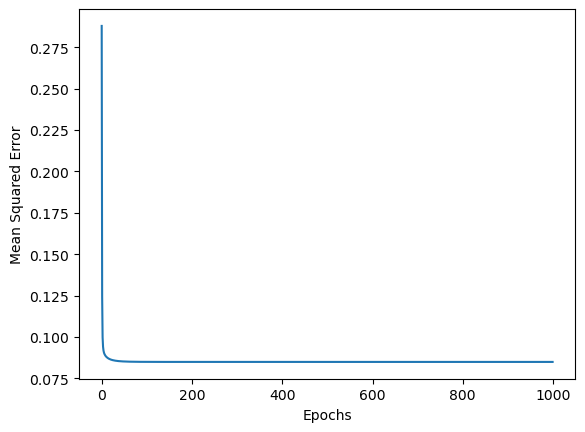

In [36]:
## Sigmoid Neuron Classification
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=0.05, display_loss=True)

In [37]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel() #binarising the output
Y_pred_val = sn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.87
Validation accuracy 0.87


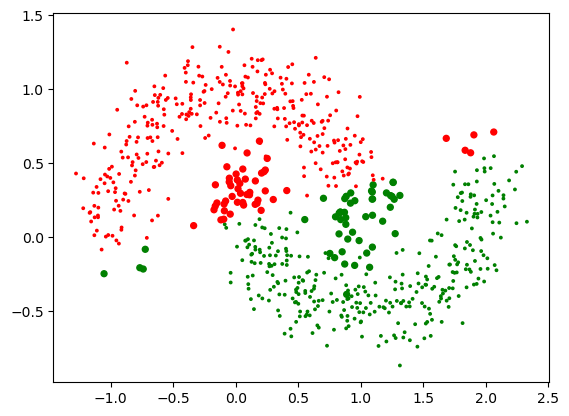

In [38]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

/var/folders/8y/_7ktt_8s6jq9l112s93q5zxh0000gn/T/ipykernel_890/3171471967.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1000 [00:00<?, ?epoch/s]

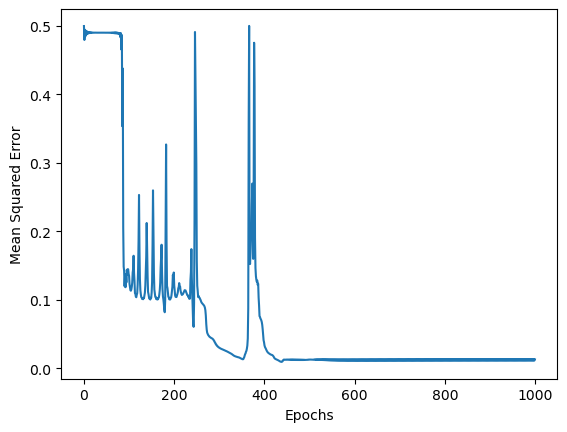

In [42]:
## Feed Forward Network
ffsnn = FFSNNetwork(2, [3, 4])
ffsnn.fit(X_train, Y_train, epochs=1000, learning_rate=.05, display_loss=True)

In [43]:
Y_pred_train = ffsnn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = ffsnn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.98
Validation accuracy 0.99


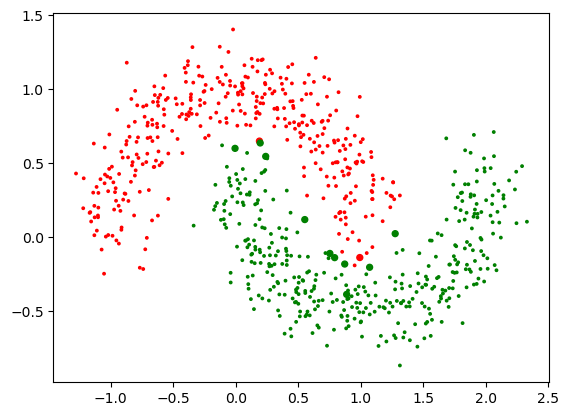

In [45]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

## Dataset-2

In [50]:
data, labels = make_circles(n_samples=1000, random_state=0, noise=0.15, factor=0.3)
print(data.shape, labels.shape)

(1000, 2) (1000,)


In [51]:
data

array([[ 0.36398311,  0.05747941],
       [ 0.06649554, -0.08501001],
       [-0.76839992, -0.85214417],
       ...,
       [ 0.0241854 , -0.00822051],
       [ 0.30937072,  0.14654516],
       [-0.28779946,  0.13375009]])

In [52]:
labels

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,

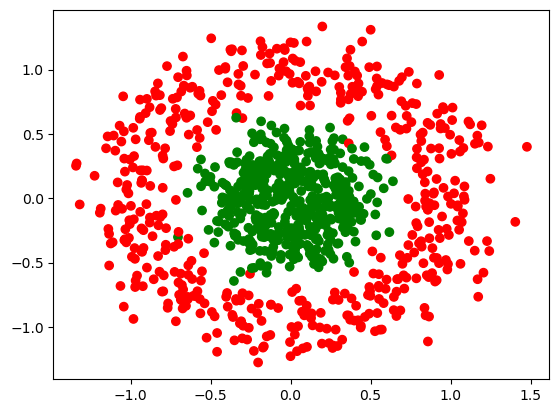

In [53]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [54]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


/var/folders/8y/_7ktt_8s6jq9l112s93q5zxh0000gn/T/ipykernel_890/1941738140.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1000 [00:00<?, ?epoch/s]

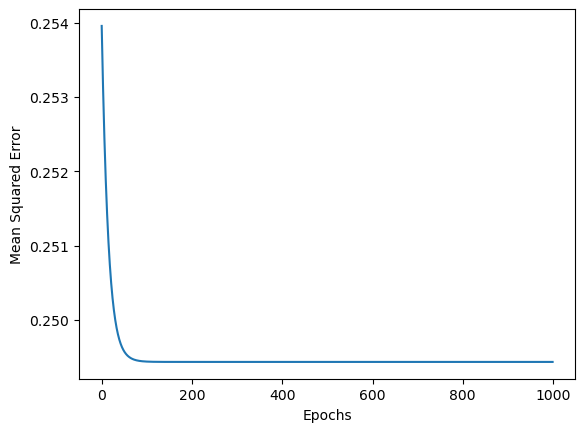

In [60]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=0.005, display_loss=True)

In [61]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel() #binarising the output
Y_pred_val = sn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.53
Validation accuracy 0.49


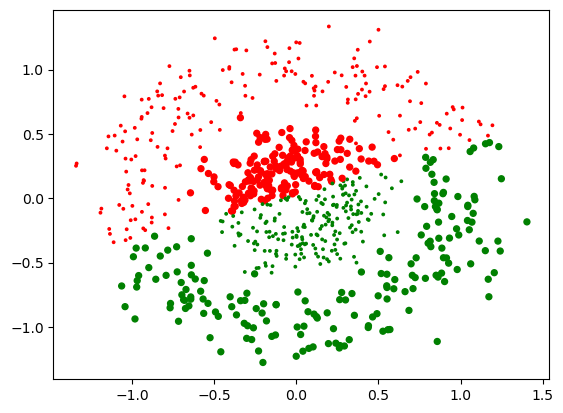

In [62]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

/var/folders/8y/_7ktt_8s6jq9l112s93q5zxh0000gn/T/ipykernel_890/3171471967.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1000 [00:00<?, ?epoch/s]

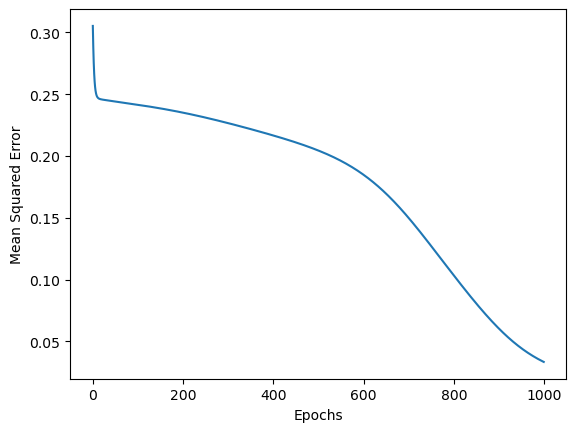

In [66]:
ffsnn = FFSNNetwork(2, [4, 5])
ffsnn.fit(X_train, Y_train, epochs=1000, learning_rate=.001, display_loss=True)

In [67]:
Y_pred_train = ffsnn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = ffsnn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.99
Validation accuracy 0.98


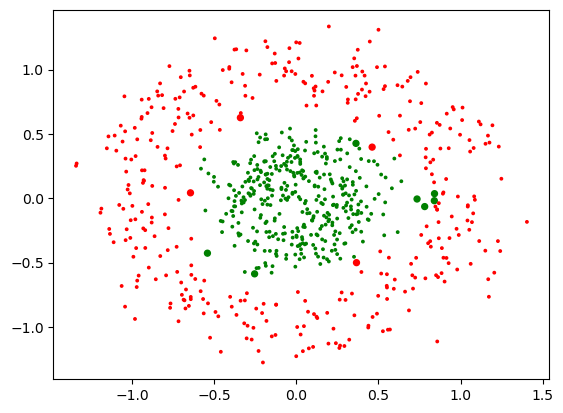

In [68]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()